# Example of MMIHCL usage between weak linkage dataset integration.

In this tutorial, we demonstrate how to use MMIHCL to integrate a weak linkage dataset. 

Here, we use the CITE-seq PBMC dataset as an example.

In [3]:
# Import the necessary dependencies.
import sys
import warnings
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

sys.path.append('../mmihcl')

from Model import *
from Utils import *
from Metrics import *
from LossUtils import *
from Preprocess import *
from Mmihcl import MMIHCL
from scib import metrics

plt.rcParams['figure.figsize'] = (6, 6)
warnings.filterwarnings('ignore')

In [4]:
# Firstly read the dataset.
dataset_name = 'CITEseq_PBMC'

shared_adata_1, shared_adata_2, all_adata_1, all_adata_2 = readDataset(dataset_name)

shared_adata_1, shared_adata_2, all_adata_1, all_adata_2

(AnnData object with n_obs × n_vars = 10000 × 180
     obs: 'celltype.l1', 'celltype.l2',
 AnnData object with n_obs × n_vars = 10000 × 180
     obs: 'celltype.l1', 'celltype.l2',
 AnnData object with n_obs × n_vars = 10000 × 20729
     obs: 'celltype.l1', 'celltype.l2',
 AnnData object with n_obs × n_vars = 10000 × 224
     obs: 'celltype.l1', 'celltype.l2')

In [5]:
# Then preprocess the dataset.
shared_adata_1, shared_adata_2, all_adata_1, all_adata_2 = preprocessAnnData(
    dataset_name=dataset_name,
    shared_adata_1=shared_adata_1,
    shared_adata_2=shared_adata_2,
    all_adata_1=all_adata_1,
    all_adata_2=all_adata_2,
    n_sample_1=None,
    n_sample_2=None
)

shared_adata_1, shared_adata_2, all_adata_1, all_adata_2

(AnnData object with n_obs × n_vars = 10000 × 177
     obs: 'celltype.l1', 'celltype.l2'
     var: 'mean', 'std'
     uns: 'log1p',
 AnnData object with n_obs × n_vars = 10000 × 177
     obs: 'celltype.l1', 'celltype.l2'
     var: 'mean', 'std'
     uns: 'log1p',
 AnnData object with n_obs × n_vars = 10000 × 1707
     obs: 'celltype.l1', 'celltype.l2'
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'log1p', 'hvg',
 AnnData object with n_obs × n_vars = 10000 × 224
     obs: 'celltype.l1', 'celltype.l2'
     var: 'mean', 'std'
     uns: 'log1p')

In [6]:
# Obtain cell annotation information from these AnnDatas for subsequent evaluation.
labels_1, labels_2 = getLabels(
    dataset_name=dataset_name,
    adata_1=shared_adata_1,
    adata_2=shared_adata_2
)

labels_1[:5], labels_2[:5]

(['Mono', 'Mono', 'CD8 T', 'DC', 'CD4 T'],
 ['Mono', 'Mono', 'CD8 T', 'DC', 'CD4 T'])

In [7]:
# Generate MMIHCL object for integration.
MMI = MMIHCL(
    shared_array_1=shared_adata_1.X,
    shared_array_2=shared_adata_2.X,
    all_array_1=all_adata_1.X,
    all_array_2=all_adata_2.X
)

In [8]:
# Set the matching specifications.
MMI.setMatchingParameters(
    n_intermediate_match=1,
    n_final_match=1,
    verbose=True
)

We will perform one-to-one matching between two datasets.


In [9]:
# Construct graph matrices over all_array_1 and all_array_2.
MMI.constructGraph(
    n_neighbors_1=15,
    n_neighbors_2=15,
    n_components_1=30,
    n_components_2=30,
    verbose=True
)

Calculating adaptively k-neighbor adjacent matrices...
Two adaptively k-neighbor adjacent matrices have been calculated.
Calculating GCN aggregate matrices...
Two GCN aggregate matrices have been calculation calculated.


In [10]:
# Find initial matching between RNA and protein modalities.
MMI.findInitialMatching(
    hyperegde_dim=32,
    n_epochs=1000,
    n_layers=2,
    learn_rate=2e-2,
    weight_decay=1e-3,
    temp=0.1,
    min_dist=1e-7,
    threshold=0.7,
    verbose=True
)

print('The accuracy of initial matching is ' + str(evalAccuracy(MMI.init_matching, labels_1, labels_2) * 100) + '%.')

Learning shared feature embeddings...
Initializing the model and optimizer...
Fitting the model...
The hypergraph-based embedding learning is complete.
Finding the initial matching...
Filtering the initial matching...
The initial matching has been found and filtered.
The accuracy of initial matching is 90.23%.


In [11]:
# Find refined matching between RNA and protein modalities.
MMI.findRefinedMatching(
    hyperegde_dim=32,
    n_epochs=1000,
    n_layers=2,
    learn_rate=2e-2,
    weight_decay=1e-3,
    temp=0.1,
    min_dist=1e-7,
    threshold=0.7,
    n_iter=1,
    n_components=20,
    max_iter=1000,
    verbose=True
)

The current number of iterations: 1.
Using CCA projection to get joint embeddings...
Learning all feature embeddings......


In [12]:
# Find final matching between RNA and protein modalities and get joint embeddings.
MMI.findFinalMatching(
    min_dist=1e-7,
    threshold=0.7,
    n_components=20,
    max_iter=1000,
    verbose=True
)

Finding the final matching...
Filtering the final matching...
The final matching has been found and filtered.
Using CCA projection to get final joint embeddings...
The final joint embeddings have been geted.


In [13]:
# Evaluate the quality of the final joint embeddings.
cca_adata = ad.AnnData(
    np.concatenate((MMI.all_array_cca_1, MMI.all_array_cca_2), axis=0), 
    dtype=np.float32
)
cca_adata.obs['data type'] = ['protein'] * MMI.all_array_cca_1.shape[0] + ['RNA'] * MMI.all_array_cca_2.shape[0]
cca_adata.obs['cell type'] = labels_1 + labels_2

sc.pp.neighbors(cca_adata, use_rep='X')
sc.tl.leiden(cca_adata, resolution=0.1, key_added='leiden')

ACC = evalAccuracy(MMI.final_matching, labels_1, labels_2)
FOSCTTM = evalFOSCTTM(MMI.all_array_cca_1, MMI.all_array_cca_2)
NMI = metrics.nmi(cca_adata, cluster_key='leiden', label_key='cell type')
ARI = metrics.ari(cca_adata, cluster_key='leiden', label_key='cell type')
ASW_label, ASW_batch = evalASWLabelNBatch(cca_adata)
GC = evalGraphConnectivity(cca_adata.X, cca_adata.obs['cell type'])

S_bio = (ACC + (1 - FOSCTTM) + NMI + ARI + ASW_label) / 5
S_batch = (GC + ASW_batch) / 2
S_overall = 0.6 * S_bio + 0.4 * S_batch

print(f'ACC: {ACC:.4f}')
print(f'FOSCTTM: {FOSCTTM:.4f}')

print(f'NMI: {NMI:.4f}')
print(f'ARI: {ARI:.4f}')
print(f'ASW_label: {ASW_label:.4f}')

print(f'GC: {GC:.4f}')
print(f'ASW_batch: {ASW_batch:.4f}')

print(f'S_bio: {S_bio:.4f}')
print(f'S_batch: {S_batch:.4f}')
print(f'S_overall: {S_overall:.4f}')

ACC: 0.9375
FOSCTTM: 0.0436
NMI: 0.8350
ARI: 0.8276
ASW_label: 0.6481
GC: 0.9737
ASW_batch: 0.9837
S_bio: 0.8409
S_batch: 0.9787
S_overall: 0.8961


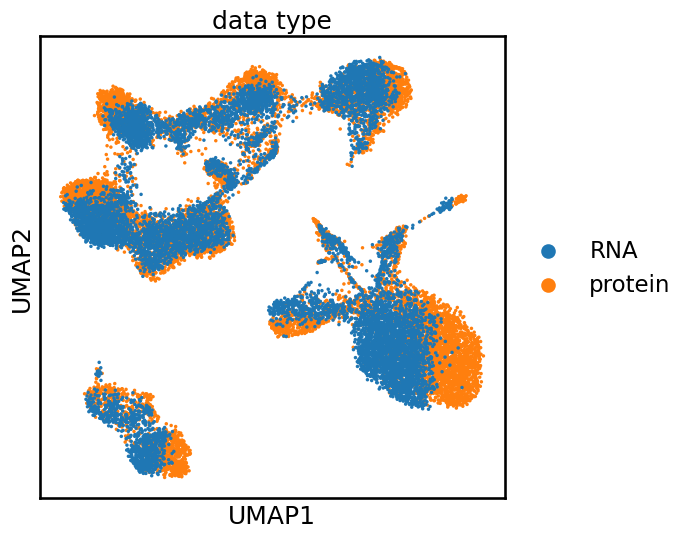

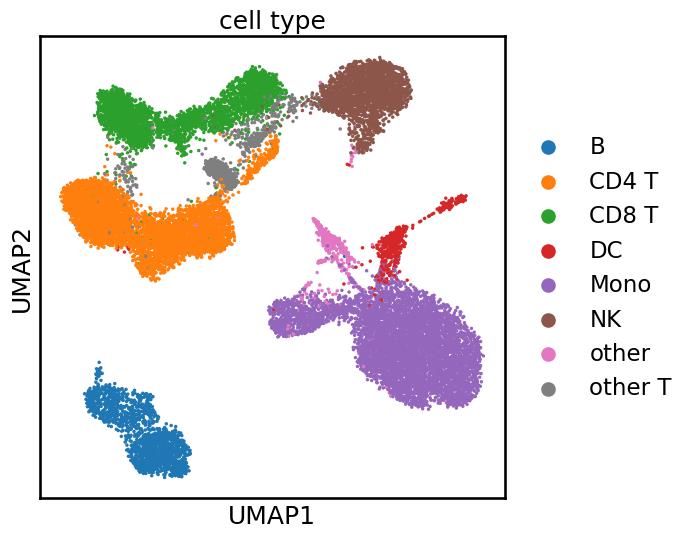

In [16]:
# Visualize the final joint embeddings using UMAP.
sc.pp.neighbors(cca_adata, n_neighbors=15)
sc.tl.umap(cca_adata)
sc.pl.umap(cca_adata, color='data type', size=25)
sc.pl.umap(cca_adata, color='cell type', size=25)